In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

import tensorflow as tf
from tensorflow import keras

In [3]:
path =  '/content/drive/MyDrive/Colab Notebooks/aidd/nia_dm.txt'
path2 =  '/content/drive/MyDrive/Colab Notebooks/aidd/label.txt'
df = pd.read_table(path)
label = pd.read_table(path2)

# 데이터 준비

In [4]:
df1 = df.iloc[:2438,:].copy()
df2 = df.iloc[2439:4877,:].copy()
df3 = df.iloc[4878:7316,:].copy()

In [5]:
col1 = ['index','CDMID', 'gender', 'age', 'date', 'Ht', 'Wt', 'BMI', 'SBP', 'DBP']
col2 = ['index','PR','HbA1c','FBG','TC','TG','LDL','HDL','Alb','BUN','Cr','CrCl']
col3 = ['index','AST', 'ALT', 'GGT', 'ALP', 'date_E']

In [6]:
df1_all = pd.DataFrame(columns = col1)
for i in range(len(df1)):
  df1_ = pd.DataFrame([list(df1.iloc[i,:])[0].split()],columns = col1)
  df1_all = pd.concat([df1_all, df1_], axis = 0)

df2_all = pd.DataFrame(columns = col2)
for i in range(len(df2)):
  df2_ = pd.DataFrame([list(df2.iloc[i,:])[0].split()],columns = col2)
  df2_all = pd.concat([df2_all, df2_], axis = 0)

df3_all = pd.DataFrame(columns = col3)
for i in range(len(df3)):
  df3_ = pd.DataFrame([list(df3.iloc[i,:])[0].split()],columns = col3)
  df3_all = pd.concat([df3_all, df3_], axis = 0)

In [7]:
label_all = pd.DataFrame([list(label.columns)[0].split()])
for i in range(len(label)):
  label_ = pd.DataFrame([list(label.iloc[i,:])[0].split()])
  label_all = pd.concat([label_all, label_], axis = 1)

In [8]:
label_all = label_all.T

In [9]:
label_all = label_all.astype({0:'int'})
label_all.columns = ['target']

In [10]:
df1_df2 = pd.merge(left = df1_all , right = df2_all, how = "left", on = "index")
df_all = pd.merge(left =df1_df2 , right = df3_all, how = "left", on = "index")

In [11]:
df_all = df_all.drop(['index'], axis = 1)

In [12]:
df_all.shape

(2438, 25)

In [13]:
df_all['target'] = np.array(label_all)

In [14]:
df_all = df_all.astype({'age':'float', 'Ht':'float', 'Wt':'float', 'BMI':'float', 'SBP':'float', 'DBP':'float', 'PR':'float',
       'HbA1c':'float', 'FBG':'float', 'TC':'float', 'TG':'float', 'LDL':'float', 'HDL':'float', 'Alb':'float', 'BUN':'float', 'Cr':'float', 'CrCl':'float',
       'AST':'float', 'ALT':'float', 'GGT':'float', 'ALP':'float'})

In [15]:
df_all['target'].value_counts()

0    2232
1     206
Name: target, dtype: int64

# 전처리

#### 시각화

In [ ]:
! pip install dataprep

     |████████████████████████████████| 2.1 MB 12.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.5 MB/s 
     |████████████████████████████████| 1.5 MB 44.0 MB/s 
     |████████████████████████████████| 943 kB 41.6 MB/s 
     |████████████████████████████████| 366 kB 49.3 MB/s 
     |████████████████████████████████| 719 kB 41.5 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 848 kB 42.5 MB/s 
     |████████████████████████████████| 158 kB 42.7 MB/s 
     |████████████████████████████████| 10.1 MB 46.3 MB/s 
     |████████████████████████████████| 160 kB 41.0 MB/s 
     |████████████████████████████████| 192 kB 34.7 MB/s 
     |████████████████████████████████| 271 kB 46.1 MB/s 
     |████████████████████████████████| 132 kB 38.5 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 1.5 MB 45.3 MB/s 
     |████████████████████████████████| 743 kB 41.1 MB/s 
  Created wheel f

In [ ]:
from dataprep.eda import create_report
create_report(df_all)

Output hidden; open in https://colab.research.google.com to view.

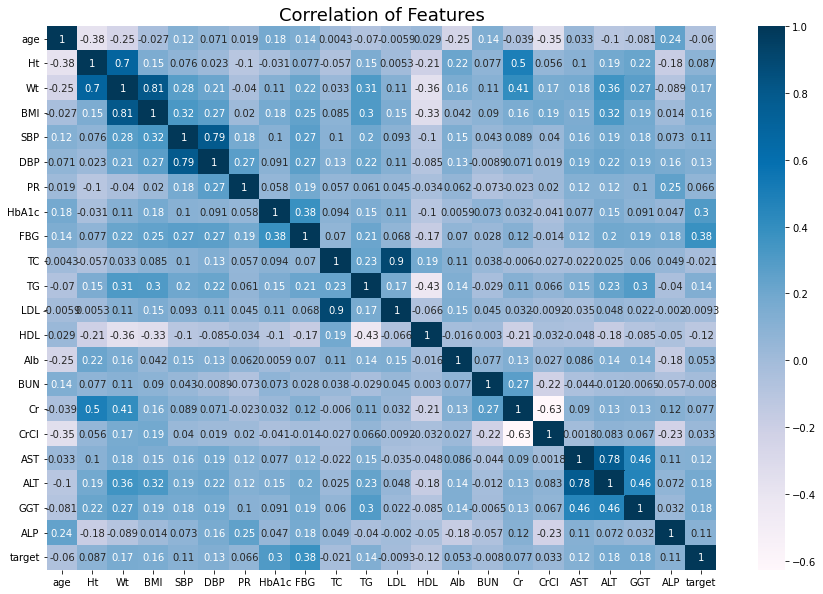

In [ ]:
plt.figure(figsize = (15,10))
plt.title('Correlation of Features',size=18)

sns.heatmap(df_all.corr(), cmap = plt.cm.PuBu, linecolor = 'white',annot =True)

#### 이상치

In [16]:
df_all['BP'] = df_all['SBP'] - df_all['DBP']
con = np.abs(df_all.corr()['target']) <= 0.1
list(df_all.corr()['target'].loc[con].index[:-1])

['age', 'Ht', 'PR', 'TC', 'LDL', 'Alb', 'BUN', 'Cr', 'CrCl']

In [17]:
def outliers(df,columns):
    outlier_indices = []
    for col in columns:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = (Q3 - Q1)*1.5
        lowest = Q1 - IQR
        highest = Q3 + IQR
        
        outlier_index = df[col][(df[col] < lowest)|(df[col]>highest)].index

        for index in list(outlier_index) :
          if index not in outlier_indices:
            outlier_indices.append(index)

           #outlier_indices.append(outlier_index)
        #outlier_indices.extend(outlier_index)
    #outlier_indices = Counter(outlier_indices)
    #multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return outlier_indices

In [18]:
outliers_to_drop = outliers(df_all,[ 'Ht', 'PR', 'TC', 'LDL', 'Alb', 'BUN', 'Cr'])
len(outliers_to_drop)

83

In [19]:
df_all.iloc[outliers_to_drop]['target'].value_counts()

0    79
1     4
Name: target, dtype: int64

In [20]:
df_all = df_all.drop(outliers_to_drop,axis=0).reset_index(drop=True)

In [21]:
df_all.columns

Index(['CDMID', 'gender', 'age', 'date', 'Ht', 'Wt', 'BMI', 'SBP', 'DBP', 'PR',
       'HbA1c', 'FBG', 'TC', 'TG', 'LDL', 'HDL', 'Alb', 'BUN', 'Cr', 'CrCl',
       'AST', 'ALT', 'GGT', 'ALP', 'date_E', 'target', 'BP'],
      dtype='object')

In [ ]:
#df_all['HbA1c_FBG_enc'] = np.where((df_all['HbA1c']>= 5.6) & (df_all['FBG']>=100), 2, np.where((df_all['HbA1c']< 5.6) & (df_all['FBG']<100), 0, 1))

In [22]:
df_all = df_all[[ 'gender', 'age', 'BMI',
       'HbA1c', 'FBG', 'TC', 'LDL', 'CrCl',
       'AST', 'ALT', 'GGT', 'ALP', 'target', 'BP']].copy()

In [23]:
df_all['target'].value_counts()

0    2153
1     202
Name: target, dtype: int64

#### Train_test_split

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)
for train_index, test_index in split.split(df_all, df_all["target"]):
    strat_train_set = df_all.loc[train_index]
    strat_val_set = df_all.loc[test_index]

In [25]:
strat_train_set.columns

Index(['gender', 'age', 'BMI', 'HbA1c', 'FBG', 'TC', 'LDL', 'CrCl', 'AST',
       'ALT', 'GGT', 'ALP', 'target', 'BP'],
      dtype='object')

In [26]:
strat_train_set.shape, strat_val_set.shape

((1884, 14), (471, 14))

In [32]:
train_y = strat_train_set['target']
val_y = strat_val_set['target']
train_x = strat_train_set.drop('target', axis = 1)
val_x = strat_val_set.drop('target', axis = 1)

In [ ]:
train_x

,gender,age,BMI,BP,HbA1c,FBG,TG,LDL,CrCl,AST,ALT,GGT,ALP
339,F,49.0,31.2,57.0,5.2,88.0,168.0,116.0,121.70,20.0,17.0,54.0,69.0
981,F,56.0,23.5,30.0,5.7,90.0,72.0,193.0,78.86,60.0,39.0,47.0,178.0
1531,M,49.0,23.9,38.0,5.3,85.0,215.0,161.0,75.20,52.0,27.0,23.0,84.0
1288,F,49.0,22.5,54.0,5.7,107.0,185.0,187.0,112.93,30.0,42.0,88.0,90.0
1207,M,62.0,28.9,48.0,5.2,104.0,130.0,93.0,80.47,56.0,51.0,77.0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,F,50.0,29.4,51.0,5.6,95.0,210.0,120.0,106.25,20.0,21.0,22.0,83.0
474,M,60.0,24.0,36.0,5.8,95.0,94.0,111.0,69.83,26.0,16.0,14.0,54.0
1986,M,57.0,22.9,51.0,5.4,83.0,65.0,151.0,67.16,23.0,20.0,32.0,112.0
1598,F,66.0,21.4,59.0,5.3,91.0,89.0,164.0,106.31,37.0,26.0,30.0,306.0


#### 스케일링 + 원핫인코딩

In [ ]:
train_x_num = train_x.drop(['gender'],axis = 1)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [30]:
num_pipeline = Pipeline([
        ('imputer', IterativeImputer()),
        ('scaler', StandardScaler()),
    ])

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(train_x_num)
cat_attribs = ['gender']
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [35]:
df_train = full_pipeline.fit_transform(train_x)
df_val = full_pipeline.transform(val_x)

# 모델링

In [48]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=df_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [42]:
epoch, batch_size = 100, 30
# Start here!!
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(df_train, train_y, epochs=epoch, batch_size= 30,
                    validation_data=(df_val, val_y),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
63/63 [==============================] - 1s 7ms/step - loss: 0.5799 - accuracy: 0.7458 - val_loss: 0.3686 - val_accuracy: 0.9002
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.3368 - accuracy: 0.9007 - val_loss: 0.2833 - val_accuracy: 0.9151
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 0.2392 - accuracy: 0.9262 - val_loss: 0.1934 - val_accuracy: 0.9427
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.1992 - accuracy: 0.9321 - val_loss: 0.1805 - val_accuracy: 0.9363
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1852 - accuracy: 0.9289 - val_loss: 0.1751 - val_accuracy: 0.9299
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 0.1673 - accuracy: 0.9368 - val_loss: 0.1595 - val_accuracy: 0.9427
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.1699 - accuracy: 0.9352 - val_loss: 0.1602 - val_accuracy: 0.9427
Epoch 8/100
6

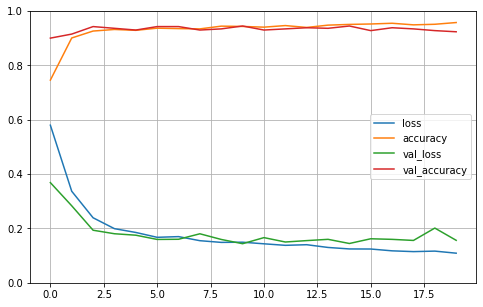

In [43]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [44]:
loss, acc = model.evaluate(df_val, val_y)

print("Loss: %.3f, Accuracy: %.3f" % (loss, acc))

15/15 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.9236
Loss: 0.156, Accuracy: 0.924


In [49]:
kfold = StratifiedKFold(n_splits = 5)

In [50]:
ET = ExtraTreesClassifier(random_state=42)
RF = RandomForestClassifier(n_estimators=500,random_state = 42)
LGB = LGBMClassifier(n_estimators=500,random_state=42)
XGB = XGBClassifier(n_estimators=500,random_state = 42)

In [53]:
ET_pred = cross_val_score(ET, df_train, train_y,  cv = kfold, n_jobs = - 1, scoring = 'accuracy')
np.mean(ET_pred)

0.9209182233760369

In [ ]:
RF_pred = cross_val_predict(RF, df_train, train_y_all,  cv = kfold, n_jobs = - 1, method = 'predict_proba')
roc_auc_score(train_y_all, RF_pred[:,1])

0.9027745384211259

In [ ]:
LGB_pred = cross_val_predict(LGB, df_train, train_y_all,  cv = kfold, n_jobs = - 1, method = 'predict_proba')
roc_auc_score(train_y_all, LGB_pred[:,1])

0.8961097093531417

In [ ]:
XGB_pred = cross_val_predict(XGB, df_train, train_y_all,  cv = kfold, n_jobs = - 1, method = 'predict_proba')
roc_auc_score(train_y_all, XGB_pred[:,1])

0.8959188817976427

In [ ]:
Estimators_final = [
    ("ET", ET),
    ('RF',RF),
#("LGB", LGB),
    ("XGB", XGB),  
]

In [ ]:
Voting_final = VotingClassifier(Estimators_final,voting='soft')

In [ ]:
final_pred = cross_val_predict(Voting_final, df_train, train_y_all,  cv = kfold, n_jobs = - 1, method = 'predict_proba')
roc_auc_score(train_y_all, final_pred[:,1])

0.9118612283169245

In [ ]:
Stacking_final = StackingClassifier(Estimators_final,final_estimator=LogisticRegression(),cv=kfold,stack_method='predict_proba')

In [ ]:
final2_pred = cross_val_predict(Stacking_final, df_train, train_y_all,  cv = kfold, n_jobs = - 1, method = 'predict_proba')
roc_auc_score(train_y_all, final2_pred[:,1])

0.9096466863148371

BMI, HbA1c, FBG 인코딩 했을 때  
EF : 0.869, RF : 0.871, LGB : 0.858, XGB : 0.861  
인코딩 안했을 때  
EF : 0.880, RF : 0.869, LGB : 0.858, XGB : 0.861

